In [2]:
import os
import re
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout, Flatten
from keras.models import load_model
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

## 2.1 Data preprocessing

In [3]:
# Read file - wonderland.txt
os.chdir('/content/drive/MyDrive/ST456-data')
filename = 'Alice.txt'
data = open(filename, 'r')
data = data.read().lower()
print ('Length of the original data: ' + str(len(data)))
data = re.sub('[^A-Za-z]+', ' ', data)
print ('Length of the clean data: ' + str(len(data)))

# Find unique characters in the data
chars = sorted(list(set(data)))
print ('Number of unique charaters in the data: ' + str(len(chars)))

Length of the original data: 164047
Length of the clean data: 154171
Number of unique charaters in the data: 27


Build two direction dictionary

In [4]:
# Map characters to integers
char_to_integer = []
for integer, char in enumerate(chars):
    char_to_integer.append((char, integer))
char_to_integer = dict(char_to_integer)
#print (char_to_integer)

# map integers to characters
integer_to_char = []
for integer, char in enumerate(chars):
    integer_to_char.append((integer, char))
integer_to_char = dict(integer_to_char)
#print (integer_to_char)

Generate features and lables

In [5]:
# Convert X(sequence) and y(one character) into integers
X_train = []
y_train = []
length_of_sequence = 50
for i in range(0, (len(data) - length_of_sequence)):
    sequence = data[i:i+length_of_sequence]
    sequence_int = []
    for char in sequence:
        sequence_int.append(char_to_integer[char])
    X_train.append(sequence_int)    
    label = data[i+length_of_sequence]
    y_train.append(char_to_integer[label])

# One-hot encoding
X=np.array(X_train)
y=np.array(y_train)
fts = np_utils.to_categorical(X)
lbl = np_utils.to_categorical(y)


##2.2 Neural network implementation and summary

In [6]:
model0 = Sequential()
model0.add(Embedding(input_dim=27, output_dim=256))
model0.add(LSTM(1024, input_shape=(50,27)))
model0.add(Dense(27, activation = 'softmax'))

model0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         6912      
                                                                 
 lstm_1 (LSTM)               (None, 1024)              5246976   
                                                                 
 dense_1 (Dense)             (None, 27)                27675     
                                                                 
Total params: 5,281,563
Trainable params: 5,281,563
Non-trainable params: 0
_________________________________________________________________


##2.3 Training and evaluation

From the result and the plot, we can see the categorical cross entropy loss decreases with the epochs, and maintains around 1.5 in the end. 

The accuracy increase with the training, and finally arrives at 51%.

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=27, output_dim=256))
model.add(LSTM(1024,kernel_initializer='glorot_uniform', stateful=True, return_sequence=True))
model.add(Dense(27, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy'])
history = model.fit(fts, lbl, epochs=50, verbose=0, shuffle=True, batch_size=64)
loss, accuracy = model.evaluate(fts, lbl)

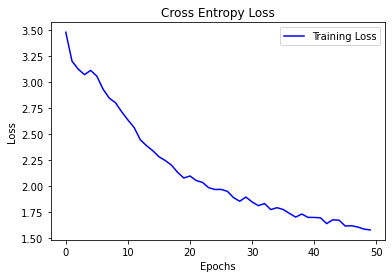

In [7]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='b', label="Training Loss")
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

##2.4 Text generation

The temperature T can increase the difference between high and low probability results without changing their sequence of magnitude. In other words, this scaling parameter can make the high probability events more probable and low probability events less probable. Using the scaling parameter to adjust the multinomial distribution is a more proper way to sample than both greedy selection which is deterministic and not empirically good, and selecting directly from multinomial distribution which may be too random.

The result shows that, when the scaling parameter T is small, the prediction will have limited word scope, which means the output is the repetition of several words. With the increase of T, the word scope becomes larger, the output also makes more sense. When T equals 1.2, the output sentence seems "readable".

The reason is that when T is small, the scaling effect on the multinomial distribution is strong, the temperature gives extra more weights to the character with higher probability.

In [11]:
# define the checkpoint
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min', save_freq=5)
callbacks_list = [checkpoint]


In [12]:
# sample the next character given the model’s predictions
def sample(pred, t):
   pred = np.asarray(pred).astype('float64')
   pred = np.log(pred) / t
   exp_pred = np.exp(pred)
   pred = exp_pred / np.sum(exp_pred)
   prob = np.random.multinomial(1, pred, 1)
   return np.argmax(prob)

In [13]:
for epoch in range(1, 11):
    print("\nepochs",epoch*5-4,"--",epoch*5)
    model.fit(fts, lbl, batch_size=64, epochs=5, steps_per_epoch=100)
    generated_text = [' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ','i']
    for t in [0.2, 0.5, 0.8, 1.0, 1.2]:
        print('\n------ temperature:', t)
        for i in range(1000):
            sampled = np.zeros((1, 50, 27))
            for ti, char in enumerate(generated_text):
                sampled[0, ti, char_to_integer[char]] = 1.
            pred = model.predict(sampled, verbose=0)[0]
            next_index = sample(pred, t)
            next_char = chars[next_index]
            generated_text += next_char
            generated_text = generated_text[1:]
            sys.stdout.write(next_char)


epochs 1 -- 5
Epoch 1/5
100/100 [==============================] - 8s 78ms/step - loss: 1.4837 - accuracy: 0.5473
Epoch 2/5
100/100 [==============================] - 8s 81ms/step - loss: 1.4487 - accuracy: 0.5589
Epoch 3/5
100/100 [==============================] - 8s 76ms/step - loss: 1.4853 - accuracy: 0.5452
Epoch 4/5
100/100 [==============================] - 8s 77ms/step - loss: 1.4841 - accuracy: 0.5491
Epoch 5/5
100/100 [==============================] - 8s 79ms/step - loss: 1.4786 - accuracy: 0.5475

------ temperature: 0.2
n a said the caterpillar and the moreltion in and the mock turtle down the more to see the moreltion and the morelter to see the mock turtle some the morelter in a little said the duchess and she said the more to she said the moreltered to said the caterpillar and the mock turtle said the more to the moreltered the morelter in a little cares in and the more to see to said the morelte in and the more to she was and she said the more to she was and the more 